In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json
import urllib.parse
import urllib.request
import re
from tqdm import tqdm
import requests
from requests import utils
import pickle

### get all pages

In [2]:
# provided dataset
from load import load_topics
topics_df, topics = load_topics('./data/topics_linked.csv.xz')
topics_df.head()

,index,Geography.Regions.Asia.Central Asia,Geography.Regions.Europe.Eastern Europe,History and Society.Military and warfare,Culture.Media.Television,History and Society.Education,Culture.Media.Books,Geography.Regions.Africa.Africa*,Culture.Visual arts.Architecture,Culture.Biography.Women,...,Geography.Regions.Asia.West Asia,STEM.Chemistry,Geography.Regions.Europe.Northern Europe,Culture.Media.Video games,Geography.Regions.Asia.Southeast Asia,Culture.Media.Entertainment,Culture.Media.Music,Geography.Regions.Asia.Asia*,Geography.Regions.Asia.North Asia,qid
0,Rosmalen,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q2001490
1,Commelinales,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q290349
2,Transport_in_Honduras,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q1130638
3,QuakeC,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q2122062
4,Food_writing,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Q5465542


In [3]:
# keyword dataset, included all the keywords we are interested in each category
# will use these keywords to search for pages
keywords_df = pd.read_csv('./data/keywords_en.csv')
keywords_df.head()

,covid symptoms,mental health,non-covid disease
0,fever,alcoholism,toothache
1,chills,panic disorder,stroke
2,cough,abuse,Cardiovascular diseases
3,shortness of breath,stress,indigestion
4,difficulty breathing,Bipolar disorder,constipation


In [4]:
def get_all_pages(pages_df, keywords):
    """
    using keywords to search for all pages
    return: a list of qid
    """
    keywords = [word.replace(" ", "_").lower() for word in keywords]
    res=[]
    page_name=[]
    page_dict = pages_df.to_dict()['qid']
    for keyword in keywords:
        for page in page_dict.keys():
            if page.lower().find(keyword)!=-1:
                res.append(page_dict[page])
                page_name.append(urllib.parse.quote(page))

    return pd.DataFrame(zip(page_name, res), columns=['index','qid'])

In [5]:
# search on the medicine & health topics, and get all need qid
all_pages = topics_df.loc[topics_df['STEM.Medicine & Health']==True, ['index','qid']].set_index('index')

covid_keywords = keywords_df['covid symptoms'].dropna().to_list()
covid_page = get_all_pages(all_pages, covid_keywords)

noncovid_keywords = keywords_df['non-covid disease'].dropna().to_list()
noncovid_page = get_all_pages(all_pages, noncovid_keywords)

mental_keywords = keywords_df['mental health'].dropna().to_list()
mental_page = get_all_pages(all_pages, mental_keywords)

In [6]:
mental_page.head()

,index,qid
0,Michigan_Alcoholism_Screening_Test,Q6837444
1,Molecular_and_epigenetic_mechanisms_of_alcoholism,Q22236242
2,Collaborative_Study_on_the_Genetics_of_Alcoholism,Q5145826
3,Disease_theory_of_alcoholism,Q5282132
4,The_Natural_History_of_Alcoholism_Revisited,Q7753254


After getting all the pages we need, we filtered out pages with very low pageviews and some irrelevant pages, then assign the category label for them manually.

### using filtered data

In [8]:
# here we filtered and categorize the date by hand, import data
covid_filtered = pd.read_csv('./data/covid_filtered.csv')
noncovid_filtered = pd.read_csv('./data/noncovid_filtered.csv')
mental_filtered = pd.read_csv('./data/mental_filtered.csv')

In [9]:
covid_filtered.head()

,index,category
0,2009_flu_pandemic_in_Canada,pandemic
1,Upper_respiratory_tract_infection,respiratory
2,Fungal_pneumonia,respiratory
3,Classification_of_pneumonia,respiratory
4,Influenza_A_virus,flu


In [10]:
# find qid for each index
for pages, filtered in [(covid_page,covid_filtered), (noncovid_page,noncovid_filtered), (mental_page,mental_filtered)]:
    res=[]
    for i in filtered['index']:
        try:
            res.append(pages.loc[pages['index']==i, 'qid'].values[0])
        except:
            res.append(np.nan)
    filtered['qid'] = res

In [11]:
# drop those nan in qid
covid_filtered = covid_filtered[covid_filtered['qid'].notna()]
noncovid_filtered = noncovid_filtered[noncovid_filtered['qid'].notna()]
mental_filtered = mental_filtered[mental_filtered['qid'].notna()]

### get pageview data from api

In [12]:
def get_wikipedia_title_from_wikidata_id(wikidata_id, lang='en', debug=False):
    """
    search pages title using qid
    return: title name in required language
    """
    
    url = (
        'https://www.wikidata.org/w/api.php'
        '?action=wbgetentities'
        '&props=sitelinks/urls'
        f'&ids={wikidata_id}'
        '&format=json')
    json_response = requests.get(url).json()
    if debug: print(wikidata_id, url, json_response) 

    entities = json_response.get('entities')    
    if entities:
        entity = entities.get(wikidata_id)
        if entity:
            sitelinks = entity.get('sitelinks')
            if sitelinks:
                if lang:
                    # filter only the specified language
                    sitelink = sitelinks.get(f'{lang}wiki')
                    if sitelink:
                        wiki_title = sitelink.get('title')
                        return wiki_title

    return None 

In [17]:
# example
get_wikipedia_title_from_wikidata_id('Q38933', lang='ko', debug=False)

'발열'

In [13]:
def get_pagestats(qid, lang, start, end, all_pages):
    
    """
    get time series of pageviews data for given qid in designated country
    return: time series DataFrame
    """
    
    title = get_wikipedia_title_from_wikidata_id(qid, lang=lang, debug=False)
    en_title = all_pages[all_pages['qid']==qid].index[0]
    if title:
        title = title.replace(" ", "_")
        title = urllib.parse.quote(title)
    else: 
        return None
    wiki = lang +'.wikipedia'
    
    # only consider human user
    url = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/"\
        + wiki + "/all-access/user/"\
        + title + "/daily/" + start + "/" + end
    try:
        page = urllib.request.urlopen(url).read()
    except:
        # print("Error reading " + url)
        return
    page = page.decode("UTF-8")
    
    pageviews = {}
    items = json.loads(page)
    for item in items["items"]:
        views = int(item["views"])
        pageviews[item['timestamp']] = views
    
    return pd.DataFrame(pageviews.values(), index=time_trans(pageviews.keys()), columns=[en_title]), qid

In [14]:
all_pages[all_pages['qid']==covid_filtered['qid'][0]].index[0]

'2009_flu_pandemic_in_Canada'

In [15]:
def time_trans(date_list):
    """
    date follows pattern '2018010100'
    return datetime object
    """
    pattern = '(\d{4})(\d{2})(\d{2})(\d{2})'
    date_list = [re.sub(pattern, '\\1-\\2-\\3',date) for date in date_list]
    return [datetime.strptime(date, '%Y-%m-%d') for date in date_list]

In [16]:
def pageview_collection(page_qid_list, start, end, lang):
    """
    collect all pageview data across time, merge them
    return: DataFrame
    """
    df_list = []
    qid_list = []
    for qid in tqdm(set(page_qid_list)):
        try:
            temp, idx = get_pagestats(qid, lang, start, end, all_pages)
            df_list.append(temp)
            qid_list.append(idx)
        except:
            continue
      
    
    # combine df for each page
    final = df_list[0]
    for m in df_list[1:]:
        if m.columns[0] in final.columns:
            continue
        else:
            final = final.join(m, how='outer')
    return final, qid_list

### Data collection

In [18]:
# collect covid_pageview data for different language
all_res={}
for lang in ["sr","it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]:
    print('Start collecting language: %s' %lang)
    pageviews_res={}
    category_res={}
    for name, pages in [('covid',covid_filtered), ('noncovid',noncovid_filtered), ('mental',mental_filtered)]:
        pageviews, qids = pageview_collection(pages['qid'], '20190101', '20200930', lang)
        pageviews_res[name] = pageviews
        category_res[name] = pages[pages['qid'].isin(qids)]
    res_dict = {'pageviews': pageviews_res,'category': category_res}
    all_res[lang]=res_dict

# store the results as pickle file                        
with open('./data/keyword_pageviews_allcountry.pickle', 'wb') as handle:
    pickle.dump(all_res, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

Start collecting language: sr


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [01:01<00:00,  3.03it/s]


Start collecting language: it


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [01:07<00:00,  2.72it/s]


Start collecting language: fr


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [01:11<00:00,  2.59it/s]


Start collecting language: en


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [01:27<00:00,  2.13it/s]


Start collecting language: nl


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [01:10<00:00,  2.62it/s]


Start collecting language: ko


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [01:00<00:00,  3.04it/s]


Start collecting language: de


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [01:08<00:00,  2.71it/s]


Start collecting language: fi


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [00:59<00:00,  3.09it/s]


Start collecting language: ja


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [01:10<00:00,  2.63it/s]


Start collecting language: no


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [01:14<00:00,  2.48it/s]


Start collecting language: sv


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [01:42<00:00,  1.81it/s]


Start collecting language: da


100%|████████████████████████████████████████████████████████████████████████████████| 185/185 [01:10<00:00,  2.61it/s]


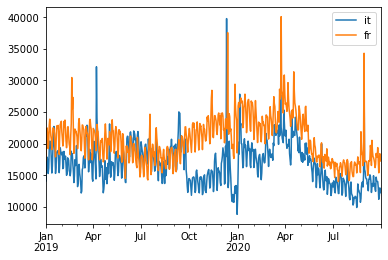

In [19]:
# simple plot to check to data completeness
temp1 = all_res['it']['pageviews']['noncovid'].sum(axis=1)
temp1.plot(label='it')
temp2 = all_res['fr']['pageviews']['noncovid'].sum(axis=1)
temp2.plot(label='fr')
plt.legend()
plt.show()

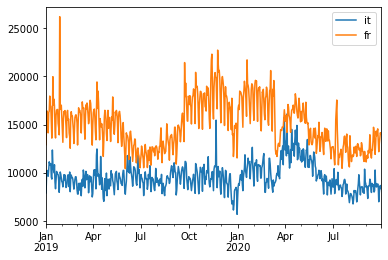

In [20]:
temp1 = all_res['it']['pageviews']['mental'].sum(axis=1)
temp1.plot(label='it')
temp2 = all_res['fr']['pageviews']['mental'].sum(axis=1)
temp2.plot(label='fr')
plt.legend()
plt.show()
# temp3 = covid_pageview_en.sum(axis=1)
# temp3.plot()

In [25]:
all_res['fr']['category']['mental']

,index,category,qid
0,Hamilton_Rating_Scale_for_Depression,NaN,Q385555
1,Combat_stress_reaction,disorder,Q1482034
2,Suicide_methods,death,Q2485083
3,Mental_disorder,disorder,Q12135
4,Domestic_violence,violence,Q156537
...,...,...,...
177,Ideas_of_reference_and_delusions_of_reference,NaN,Q2215516
179,Diagnostic_and_Statistical_Manual_of_Mental_Di...,NaN,Q201561
181,Abuse,violence,Q600571
183,Dementia,mild,Q83030
